In [1]:
import joblib
import numpy as np
import pandas as pd

# Load saved models
rf = joblib.load('../Phase_3/random_forest_model.pkl')
ridge = joblib.load('../Phase_3/ridge_model.pkl')
svr = joblib.load('../Phase_3/svr_model.pkl')

# Load test features
X_test = pd.read_csv('../Phase_3/X_test.csv')
y_test = pd.read_csv('../Phase_3/y_test.csv')

print("✅ Models and test data loaded for Phase 4.")


✅ Models and test data loaded for Phase 4.


# Compute Failure Probability
#### Here, we will use the predictions from the Random Forest Regressor as a proxy for failure probability.
#### This is just a simple approach; if you are using classifiers, you can extract probabilities directly.


In [2]:
y_pred_rf = rf.predict(X_test)  # Get the predictions for time to next failure (in cycles)
failure_probabilities = np.clip(y_pred_rf / y_pred_rf.max(), 0, 1)  # Scale the prediction to [0, 1] for probability

print(failure_probabilities[:10])

[0.96968426 0.74002943 0.68002118 0.96092829 0.95218135 0.96865851
 0.73636613 0.83867749 0.74157557 0.85056784]


# Compute Time Left to Failure
#### We will use the predictions from the Random Forest Regressor as the time left to failure.

In [3]:
time_left_to_failure = y_pred_rf  # These are the regression outputs (predicted time left to failure)

print(time_left_to_failure[:10]) 

[85.69450018 65.39907386 60.09592777 84.92070339 84.14770545 85.60385097
 65.07533494 74.11695891 65.53571145 75.16775194]


# Calculate Raw Risk Score

In [4]:
raw_risk_score = failure_probabilities * time_left_to_failure

print(raw_risk_score[:10]) 

[83.09660779 48.39723954 40.86650369 81.602706   80.12387618 82.92089854
 47.91927284 62.16022502 48.59968248 63.93527223]


# Apply Min-Max Normalization
### We will now normalize the Raw Risk Score using Min-Max Normalization to bring the scores into the range [0, 1]. This helps in comparing the risk scores across different engines.

In [5]:
min_score = raw_risk_score.min()
max_score = raw_risk_score.max()

# Normalize the risk score
normalized_risk_score = (raw_risk_score - min_score) / (max_score - min_score)

print(normalized_risk_score[:10])

[0.94026656 0.54748451 0.46223979 0.92335623 0.90661651 0.93827761
 0.54207413 0.70327564 0.54977608 0.72336841]


# Apply Urgency-Based Inversion Normalization
#### Alternatively, you can apply an Urgency-Based Inversion, which gives higher risk scores to engines with less time to failure (higher urgency).

In [6]:
# Adding a small constant (1e-6) to avoid division by zero
normalized_urgency_risk_score = failure_probabilities / (time_left_to_failure + 1e-6)

print(normalized_urgency_risk_score[:10])  # Show first 10 urgency-based risk scores

[0.01131559 0.01131559 0.01131559 0.01131559 0.01131559 0.01131559
 0.01131559 0.01131559 0.01131559 0.01131559]


# Create Alerts Based on Risk Score
#### Now, you can set a threshold (e.g., 0.7) for the normalized risk score. If any engine's risk score exceeds this threshold, it will trigger a maintenance alert.

In [7]:
threshold = 0.7  # Set threshold for risk score to trigger an alert
alerts = normalized_risk_score > threshold  # Boolean array for engines that exceed the threshold

# Display alerts
if np.any(alerts):
    print("⚠️ Maintenance Alert! Risk score exceeds threshold.")
else:
    print("✅ All engines are within safe risk limits.")


⚠️ Maintenance Alert! Risk score exceeds threshold.


# Visualize the Risk Score Over Time
#### You can plot the normalized risk score and the urgency-based risk score over the time left to failure for each engine to observe trends.

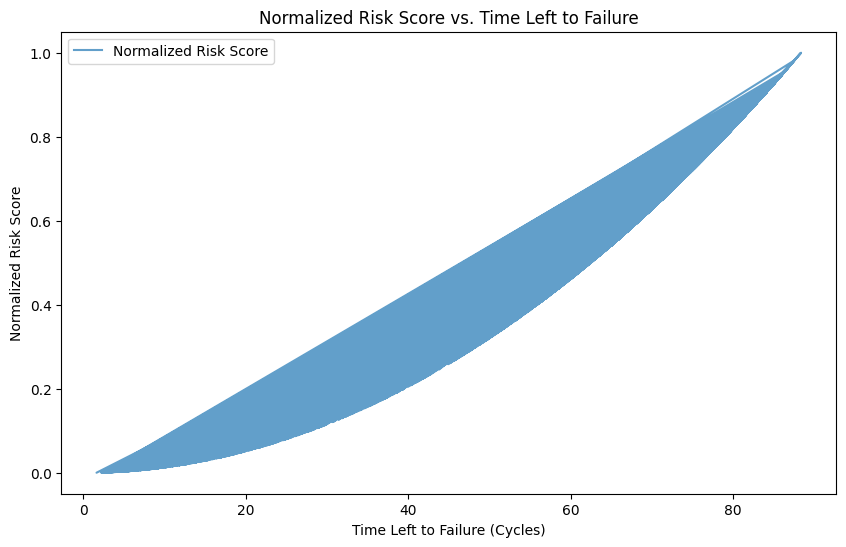

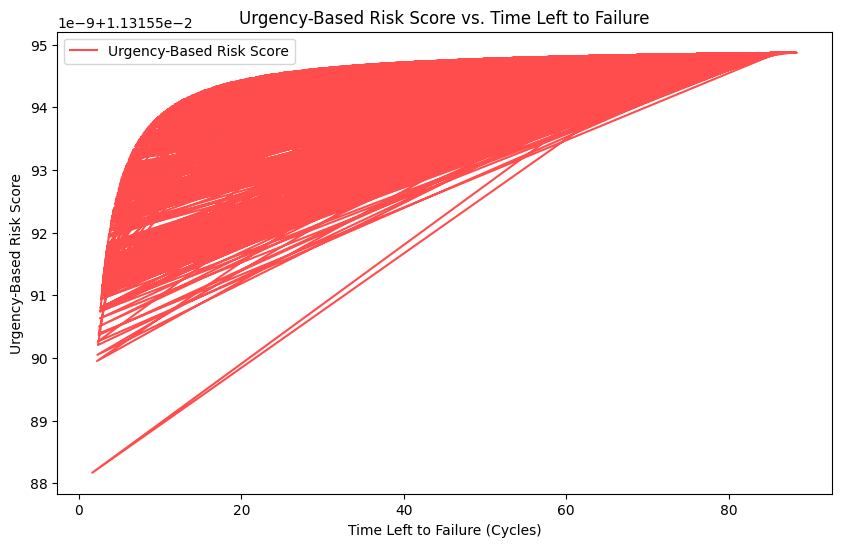

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(time_left_to_failure, normalized_risk_score, label='Normalized Risk Score', alpha=0.7)
plt.xlabel('Time Left to Failure (Cycles)')
plt.ylabel('Normalized Risk Score')
plt.title('Normalized Risk Score vs. Time Left to Failure')
plt.legend()
plt.show()

# Plot Urgency-Based Risk Score
plt.figure(figsize=(10, 6))
plt.plot(time_left_to_failure, normalized_urgency_risk_score, label='Urgency-Based Risk Score', color='red', alpha=0.7)
plt.xlabel('Time Left to Failure (Cycles)')
plt.ylabel('Urgency-Based Risk Score')
plt.title('Urgency-Based Risk Score vs. Time Left to Failure')
plt.legend()
plt.show()


# Working specifically on stage 4

In [11]:
classifier = joblib.load('../Phase_3/classifier_model.pkl')

In [12]:
# Get failure probability (probability of Stage 4) from the classifier
stage_probs = classifier.predict_proba(X_test)
failure_prob = stage_probs[:, 4]  # probability of Stage 4

In [13]:
# Get time predictions (regression output) from the random forest model
time_left_rf = rf.predict(X_test)


In [14]:
# Combine the results into a DataFrame
results = pd.DataFrame({
    'Failure_Probability': failure_prob,
    'Time_Left_RF': time_left_rf
})

results.head()

,Failure_Probability,Time_Left_RF
0,0.0,85.694500
1,0.0,65.399074
2,0.1,60.095928
3,0.0,84.920703
4,0.0,84.147705


In [15]:
# Step 1: Calculate Raw Risk Score (Failure Probability * Time Left)
results['Raw_Risk_Score'] = results['Failure_Probability'] * results['Time_Left_RF']

# Step 2: Normalize the Risk Score using Min-Max Scaling
min_score = results['Raw_Risk_Score'].min()
max_score = results['Raw_Risk_Score'].max()
results['Normalized_Risk_Score'] = (results['Raw_Risk_Score'] - min_score) / (max_score - min_score)

# Step 3: Calculate Urgency-Based Inversion Risk Score
results['Urgency_Risk_Score'] = results['Failure_Probability'] / (results['Time_Left_RF'] + 1e-6)  # Added epsilon to avoid division by zero

# Step 4: Issue Alerts based on Normalized Risk Score (e.g., if > 0.7)
threshold = 0.7
results['Maintenance_Alert'] = results['Normalized_Risk_Score'] > threshold

In [16]:
# Print maintenance alert message if condition is met
if results['Maintenance_Alert'].any():
    print("⚠️ Maintenance Alert! Engines at risk.")

⚠️ Maintenance Alert! Engines at risk.


In [17]:
# Assuming 'Engine no' is part of the df and aligns with the results
df = pd.read_csv('../Phase_1/train_FD001_phase_1.csv')  # Reload full data to get 'Engine no' and 'Num cycles'

df['Risk_Score_Trend'] = results['Normalized_Risk_Score']
df['Urgency_Risk_Score_Trend'] = results['Urgency_Risk_Score']

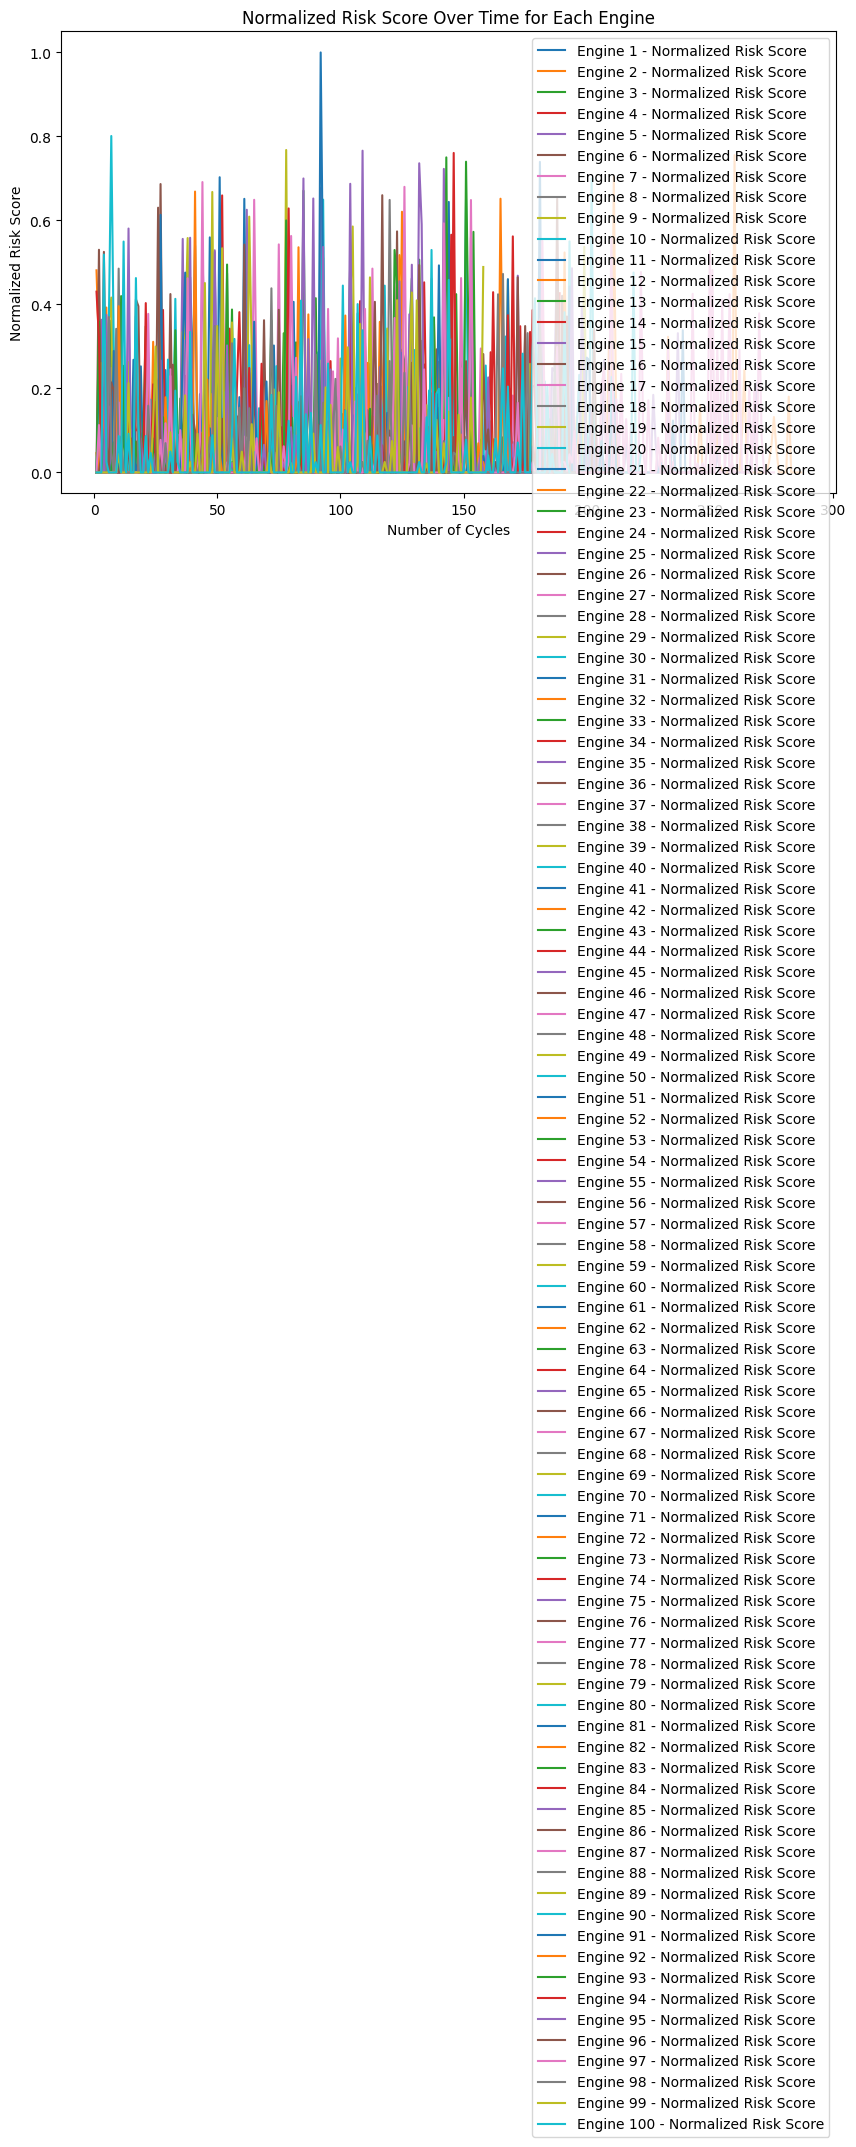

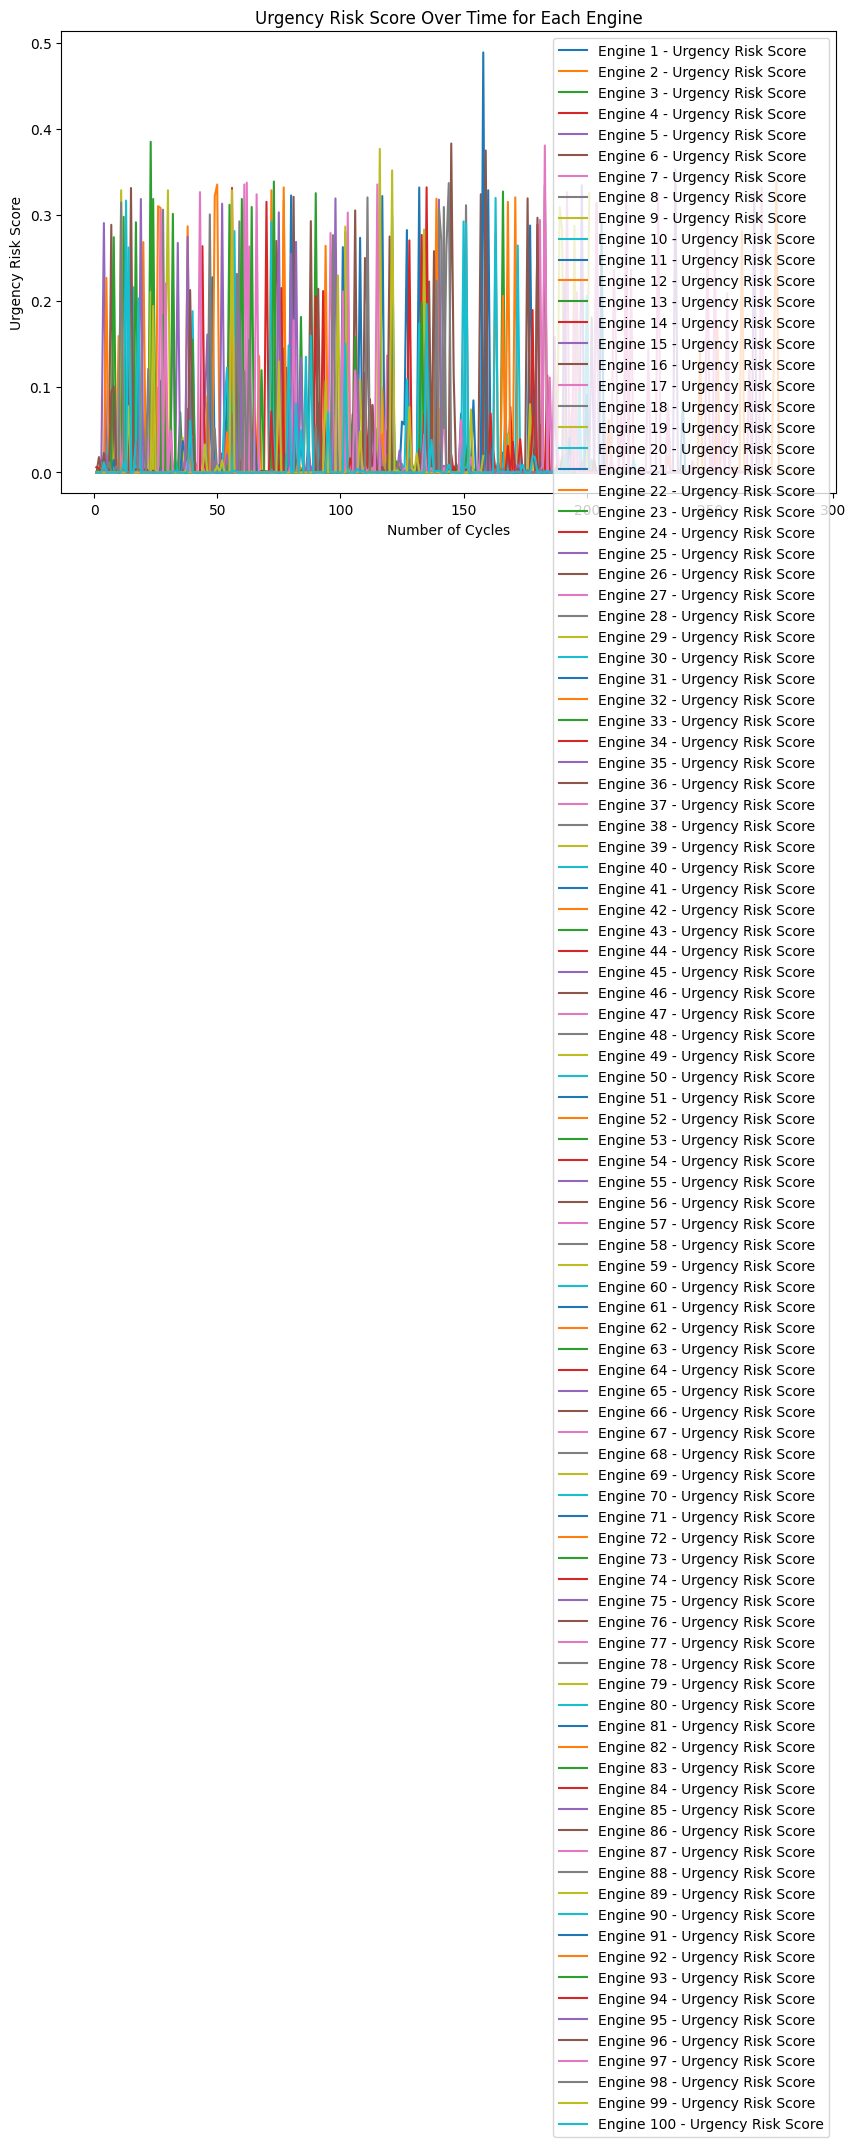

In [18]:
# Plot Risk Score Trend Over Time for each engine (Normalized Risk Score)
plt.figure(figsize=(10, 6))
for engine in df['Engine no'].unique():  # Assuming 'Engine no' is in df
    engine_data = df[df['Engine no'] == engine]
    plt.plot(engine_data['Num cycles'], engine_data['Risk_Score_Trend'], label=f'Engine {engine} - Normalized Risk Score')

plt.xlabel('Number of Cycles')
plt.ylabel('Normalized Risk Score')
plt.title('Normalized Risk Score Over Time for Each Engine')
plt.legend()
plt.show()  # Display the plot

# Plot Urgency Risk Score Trend Over Time for each engine
plt.figure(figsize=(10, 6))
for engine in df['Engine no'].unique():  # Assuming 'Engine no' is in df
    engine_data = df[df['Engine no'] == engine]
    plt.plot(engine_data['Num cycles'], engine_data['Urgency_Risk_Score_Trend'], label=f'Engine {engine} - Urgency Risk Score')

plt.xlabel('Number of Cycles')
plt.ylabel('Urgency Risk Score')
plt.title('Urgency Risk Score Over Time for Each Engine')
plt.legend()
plt.show()  # Display the plot

In [19]:
results.head()

,Failure_Probability,Time_Left_RF,Raw_Risk_Score,Normalized_Risk_Score,Urgency_Risk_Score,Maintenance_Alert
0,0.0,85.694500,0.000000,0.000000,0.000000,False
1,0.0,65.399074,0.000000,0.000000,0.000000,False
2,0.1,60.095928,6.009593,0.175193,0.001664,False
3,0.0,84.920703,0.000000,0.000000,0.000000,False
4,0.0,84.147705,0.000000,0.000000,0.000000,False


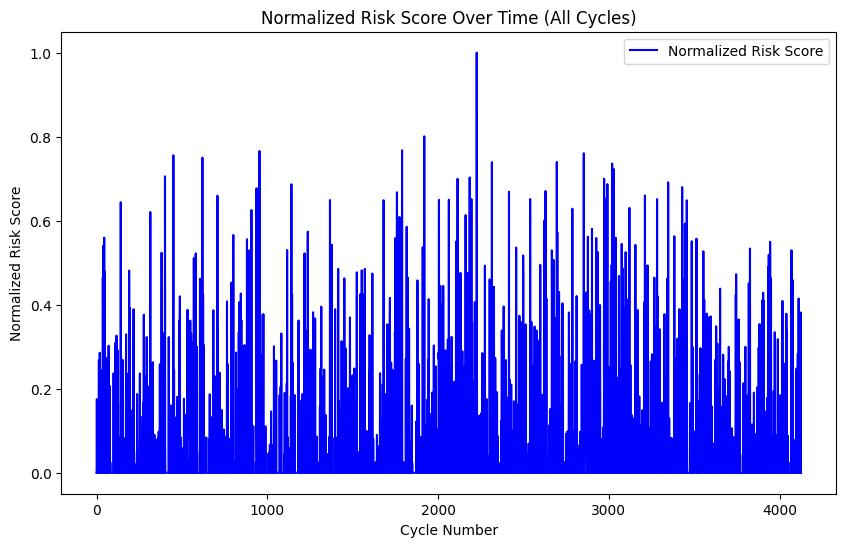

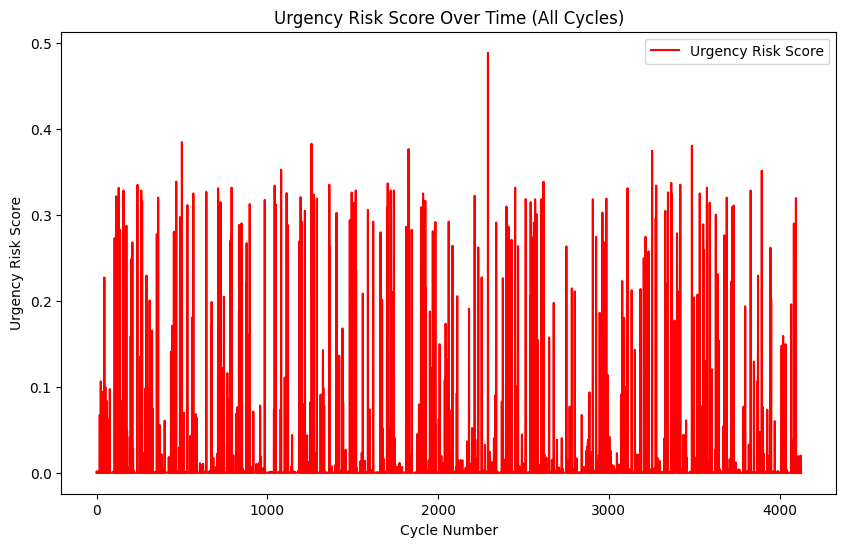

In [20]:
# Plot the overall Risk Score (Normalized Risk Score) Over Time (Cycles)
plt.figure(figsize=(10, 6))
plt.plot(results['Normalized_Risk_Score'], label='Normalized Risk Score', color='b')
plt.xlabel('Cycle Number')
plt.ylabel('Normalized Risk Score')
plt.title('Normalized Risk Score Over Time (All Cycles)')
plt.legend()
plt.show()  # Display the plot

# Plot the overall Urgency Risk Score Over Time (Cycles)
plt.figure(figsize=(10, 6))
plt.plot(results['Urgency_Risk_Score'], label='Urgency Risk Score', color='r')
plt.xlabel('Cycle Number')
plt.ylabel('Urgency Risk Score')
plt.title('Urgency Risk Score Over Time (All Cycles)')
plt.legend()
plt.show()  # Display the plot